In [1]:
import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np
import GPy
import ipyvolume
%matplotlib inline
color1='#150e5e'
color2='#867fd6'
sns.set_context('talk')
from matplotlib import animation, rc
import matplotlib.pyplot as plt
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

## Univariate Gaussian

In [3]:
from scipy.stats import norm

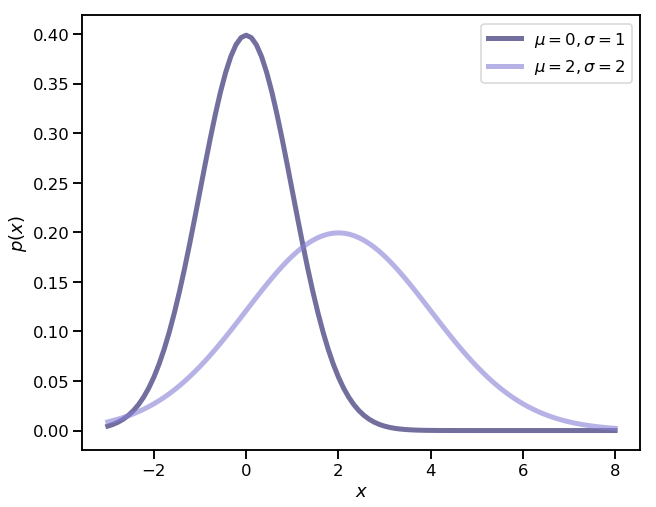

In [4]:
fig, ax = plt.subplots(1, 1,figsize=(10,8))
x = np.linspace(-3,
                8, 100)
ax.plot(x, norm.pdf(x),
       '-',c=color1, lw=5, alpha=0.6, label=r'$\mu=0,\sigma=1$')
ax.plot(x, norm.pdf(x,2,2),
       '-',c=color2, lw=5, alpha=0.6, label=r'$\mu=2,\sigma=2$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p(x)$')
ax.legend()
fig.savefig('./Slides/assets/univariateGaussian.png')

## Multivariate Gaussain

In [5]:
dist1=np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),100000)
dist2=np.random.multivariate_normal([0,0],np.array([[1,0.8],[0.8,1]]),100000)

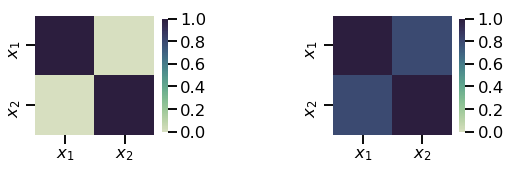

In [30]:
fig,ax=plt.subplots(1,2,figsize=(8,4))
sns.heatmap(np.array([[1,0],[0,1]]),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True),ax=ax[0],square=True,xticklabels=[r'$x_1$',r'$x_2$'],
            yticklabels=[r'$x_1$',r'$x_2$'],vmin=0,vmax=1,cbar_kws={"shrink": .52})
sns.heatmap(np.array([[1,0.8],[0.8,1]]),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True),ax=ax[1],square=True,xticklabels=[r'$x_1$',r'$x_2$'],
            yticklabels=[r'$x_1$',r'$x_2$'],vmin=0,vmax=1,cbar_kws={"shrink": .52},)
plt.subplots_adjust(wspace=1.0)
plt.savefig('./Slides/assets/heatmap_cov.png')

<Figure size 720x720 with 0 Axes>

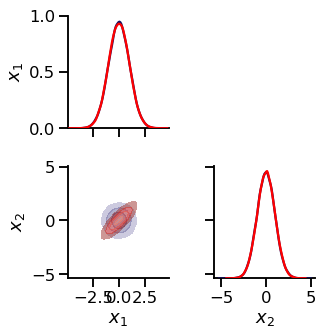

In [6]:
plt.figure(figsize=(10,10))
g=sns.PairGrid(pd.DataFrame(dist1,columns=[r'$x_1$',r'$x_2$']))
g.map_diag(sns.kdeplot,color=color1)
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap=sns.light_palette(color1, n_colors=5, reverse=False, as_cmap=True),alpha=0.5,n_levels=4)

g.data=pd.DataFrame(dist2,columns=[r'$x_1$',r'$x_2$'])
g.map_diag(sns.kdeplot,color='Red')
g.map_lower(sns.kdeplot,shade=True,shade_lowest=False,cmap='Reds_d',alpha=0.5,n_levels=4)
g.axes[0,1].set_axis_off()
plt.savefig('./Slides/assets/MultivariateGaussian.png')

## Gaussian Process

In [2]:
def get_circular_samples(X,Y,X_pred,model,num_theta=10,num_samps=5):
    K_Ks=model.kern.K(X,X_pred)
    K_K=model.kern.K(X,X)
    Ks_K=model.kern.K(X_pred,X)
    Ks_Ks=model.kern.K(X_pred,X_pred)
    mu_samp=np.matmul(Ks_K,np.matmul(np.linalg.inv(K_K),Y))
    kernel=Ks_Ks-np.matmul(np.matmul(Ks_K,np.linalg.inv(K_K)),K_Ks)
    samps=kern_circular_sample(kernel,mu_samp,num_samps=num_samps,num_theta=num_theta)
    return samps

In [3]:
def kern_circular_sample(K, mu=None, filename=None, fig=None, num_samps=5, num_theta=200, diagrams='./diagrams'):

    """Make an animation of a circular sample from a covariance function."""

    n = K.shape[0]


    R1 = np.random.normal(size=(n, num_samps))
    U1 = np.dot(R1,np.diag(1/np.sqrt(np.sum(R1*R1, axis=0))))
    R2 = np.random.normal(size=(n, num_samps))
    R2 = R2 - np.dot(U1,np.diag(np.sum(R2*U1, axis=0)))
    R2 = np.dot(R2,np.diag(np.sqrt(np.sum(R1*R1, axis=0))/np.sqrt(np.sum(R2*R2, axis=0))))
    L = np.linalg.cholesky(K+np.diag(np.ones((n)))*1e-4)
    samps=np.empty((n,num_theta,num_samps))
    tau = 2*np.pi
    for i in range(0,num_theta):
        theta = float(i)/num_theta*tau
        xc = np.cos(theta)
        yc = np.sin(theta)
        # generate 2d basis in t-d space
        coord = xc*R1 + yc*R2
        y = np.dot(L,coord)
        
        samps[:,i,:]=y + mu
    return samps

In [10]:
kernel = GPy.kern.RBF(input_dim=1)
X=np.array([[1.0],[10.0]])
Y=np.array([[1.0],[1.0]])
kernel.lengthscale.constrain_fixed(3)
m = GPy.models.GPRegression(X,Y,kernel)
#m.optimize()

In [184]:
def compute_kernel(X, X2, kernel, **kwargs):
    K = np.zeros((X.shape[0], X2.shape[0]))
    for i in np.arange(X.shape[0]):
        for j in np.arange(X2.shape[0]):
            K[i, j] = kernel(X[i, :], X2[j, :], **kwargs)
        
    return K

## Animation with two points, short lengthscale

 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning:Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.


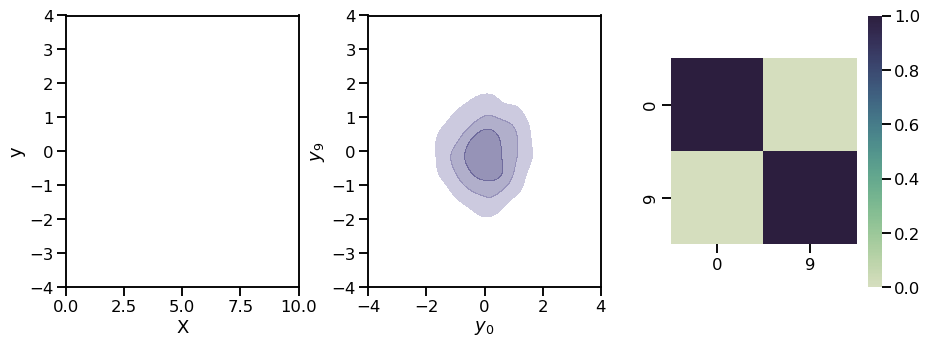

In [125]:
kernel = GPy.kern.RBF(input_dim=1)
X=np.array([[1.0],[10.0]])
Y=np.array([[1.0],[1.0]])
kernel.lengthscale.constrain_fixed(3)
m = GPy.models.GPRegression(X,Y,kernel)


x=np.arange(0,10)[:,None]
samps_2=kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=5, num_theta=40, diagrams='./diagrams')


from matplotlib import animation, rc
import matplotlib.pyplot as plt
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=False)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
lines=[]
points=[]

colors=sns.color_palette('colorblind')
for i in range(samps_2.shape[2]):
    lines.append(ax[0].plot([], [],'o-', lw=0.5,color=colors[i])[0])

K=kernel.K(x)
ind=[0, 9]
dist1=np.random.multivariate_normal([0,0],K[ind][:, ind],1000)
sns.kdeplot(pd.DataFrame(dist1,columns=[r'$x_1$',r'$x_2$']),shade=True,shade_lowest=False,
            cmap=sns.light_palette(color1, n_colors=5, reverse=False, as_cmap=True),alpha=0.5,n_levels=4,ax=ax[1])# initialization function: plot the background of each frame
for i in range(samps_2.shape[2]):
    points.append(ax[1].scatter([0], [0],color=colors[i]))

sns.heatmap(kernel.K(x[ind]),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True),ax=ax[2],square=True,xticklabels=x[ind].flatten(),
            yticklabels=x[ind].flatten(),vmin=0,vmax=1)
    
ax[0].set_xlim(0,10)
ax[0].set_ylim(-4,4)
ax[0].set_xlabel('X')
ax[0].set_ylabel('y')
ax[1].set_xlabel(r'$y_0$')
ax[1].set_ylabel(r'$y_9$')
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-4,4)

def init():
    for s in range(0,samps_2.shape[2]):
        lines[s].set_data([], [])
        points[s].set_offsets(np.c_[[],[]] )

    return (*lines,*points)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samps_2.shape[2]):
        lines[s].set_data(x[ind],samps_2[ind,i,s])
        points[s].set_offsets(np.c_[samps_2[ind[0],i,s],samps_2[ind[1],i,s]])
    return (*lines,*points)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samps_2.shape[1], interval=100, blit=True)

In [126]:
anim

In [127]:
anim.save('./Slides/assets/Two_points_small_l.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

## Animation with two points, large lengthscale

 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning:Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.


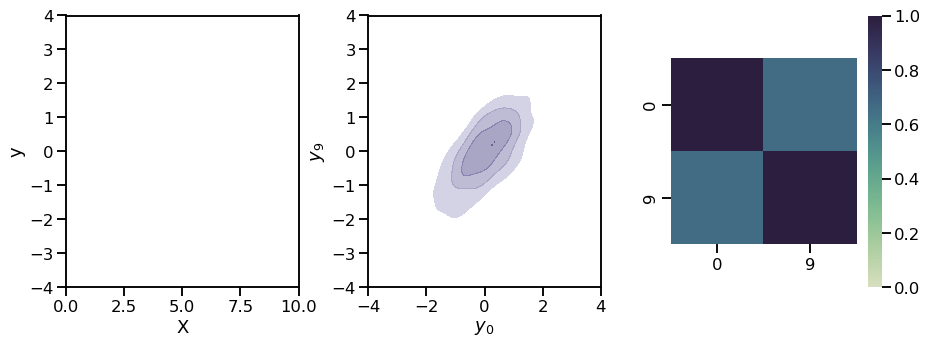

In [128]:
kernel = GPy.kern.RBF(input_dim=1)
X=np.array([[1.0],[10.0]])
Y=np.array([[1.0],[1.0]])
kernel.lengthscale.constrain_fixed(10)
m = GPy.models.GPRegression(X,Y,kernel)


x=np.arange(0,10)[:,None]
samps_2=kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=5, num_theta=40, diagrams='./diagrams')


from matplotlib import animation, rc
import matplotlib.pyplot as plt
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=False)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
lines=[]
points=[]

colors=sns.color_palette('colorblind')
for i in range(samps_2.shape[2]):
    lines.append(ax[0].plot([], [],'o-', lw=0.5,color=colors[i])[0])

K=kernel.K(x)
ind=[0, 9]
dist1=np.random.multivariate_normal([0,0],K[ind][:, ind],1000)
sns.kdeplot(pd.DataFrame(dist1,columns=[r'$x_1$',r'$x_2$']),shade=True,shade_lowest=False,
            cmap=sns.light_palette(color1, n_colors=5, reverse=False, as_cmap=True),alpha=0.5,n_levels=4,ax=ax[1])# initialization function: plot the background of each frame
for i in range(samps_2.shape[2]):
    points.append(ax[1].scatter([0], [0],color=colors[i]))

sns.heatmap(kernel.K(x[ind]),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True),ax=ax[2],square=True,xticklabels=x[ind].flatten(),
            yticklabels=x[ind].flatten(),vmin=0,vmax=1)
    
ax[0].set_xlim(0,10)
ax[0].set_ylim(-4,4)
ax[0].set_xlabel('X')
ax[0].set_ylabel('y')
ax[1].set_xlabel(r'$y_0$')
ax[1].set_ylabel(r'$y_9$')
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-4,4)

def init():
    for s in range(0,samps_2.shape[2]):
        lines[s].set_data([], [])
        points[s].set_offsets(np.c_[[],[]] )

    return (*lines,*points)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samps_2.shape[2]):
        lines[s].set_data(x[ind],samps_2[ind,i,s])
        points[s].set_offsets(np.c_[samps_2[ind[0],i,s],samps_2[ind[1],i,s]])
    return (*lines,*points)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samps_2.shape[1], interval=100, blit=True)

In [129]:
anim

In [130]:
anim.save('./Slides/assets/Two_points_large_l.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

## Animation with many points

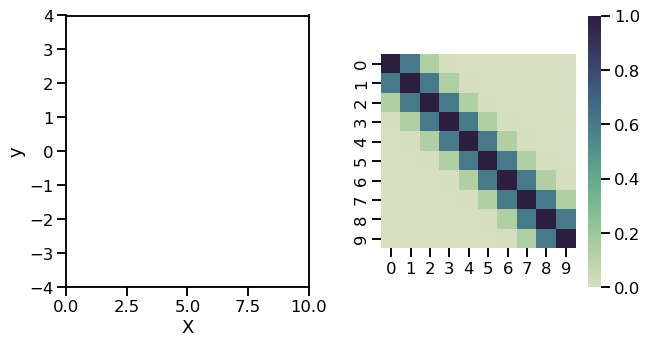

In [131]:
kernel = GPy.kern.RBF(input_dim=1)
X=np.array([[1.0],[10.0]])
Y=np.array([[1.0],[1.0]])
kernel.lengthscale.constrain_fixed(1)
m = GPy.models.GPRegression(X,Y,kernel)


x=np.arange(0,10)[:,None]
samps_2=kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=5, num_theta=40, diagrams='./diagrams')


from matplotlib import animation, rc
import matplotlib.pyplot as plt
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=False)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
lines=[]
points=[]

colors=sns.color_palette('colorblind')
for i in range(samps_2.shape[2]):
    lines.append(ax[0].plot([], [],'o-', lw=0.5,color=colors[i])[0])

K=kernel.K(x)
ind=[0, 9]
dist1=np.random.multivariate_normal([0,0],K[ind][:, ind],1000)
#sns.kdeplot(pd.DataFrame(dist1,columns=[r'$x_1$',r'$x_2$']),shade=True,shade_lowest=False,
#            cmap=sns.light_palette(color1, n_colors=5, reverse=False, as_cmap=True),alpha=0.5,n_levels=4,ax=ax[1])# initialization function: plot the background of each frame
#for i in range(samps_2.shape[2]):
    #points.append(ax[1].scatter([0], [0],color=colors[i]))

sns.heatmap(kernel.K(x),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True),ax=ax[1],square=True,xticklabels=x.flatten(),
            yticklabels=x.flatten(),vmin=0,vmax=1)
    
ax[0].set_xlim(0,10)
ax[0].set_ylim(-4,4)
ax[0].set_xlabel('X')
ax[0].set_ylabel('y')
#ax[1].set_xlabel(r'$y_0$')
#ax[1].set_ylabel(r'$y_9$')
#ax[1].set_xlim(-4,4)
#ax[1].set_ylim(-4,4)

def init():
    for s in range(0,samps_2.shape[2]):
        lines[s].set_data([], [])
        #points[s].set_offsets(np.c_[[],[]] )

    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samps_2.shape[2]):
        lines[s].set_data(x,samps_2[:,i,s])
        #points[s].set_offsets(np.c_[samps_2[ind[0],i,s],samps_2[ind[1],i,s]])
    return (lines)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samps_2.shape[1], interval=100, blit=True)

In [132]:
anim

In [133]:
anim.save('./Slides/assets/manypoints_small_l.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

## Squared exponential covariance function

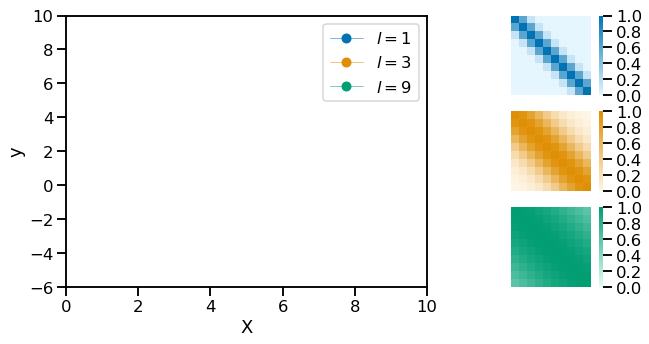

In [134]:
kernels=[]
lengthscales=[1,3,9]
x=np.arange(0,10)[:,None]
samples=[]
for i in range(0,len(lengthscales)):
    kernel = GPy.kern.RBF(input_dim=1)
    X=np.array([[1.0],[10.0]])
    Y=np.array([[1.0],[1.0]])
    kernel.lengthscale.constrain_fixed(lengthscales[i])
    kernels.append(kernel)
    
    samples.append(kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=1, num_theta=40, diagrams='./diagrams'))
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(0,10)
lineplot.set_ylim(-6,10)
lineplot.set_xlabel('X')
lineplot.set_ylabel('y')
colors=sns.color_palette('colorblind')

cov_matrices=[]
for i in range(0,len(samples)):
    lines.append(lineplot.plot([], [],'o-', lw=0.5,color=colors[i],label=r'$l=$'+str(lengthscales[i]))[0])
    cov_matrices.append(fig.add_subplot(grid[i, 2]))
    sns.heatmap(kernels[i].K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrices[i],square=True,xticklabels=[],
            yticklabels=[],vmin=0,vmax=1)
    
lineplot.legend()    
def init():
    for s in range(0,len(samples)):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,len(samples)):
        lines[s].set_data(x,samples[s][:,i])
    return (lines)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples[0].shape[1], interval=100, blit=True)



In [135]:
anim

In [136]:
anim.save('./Slides/assets/RBF_covfunc.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

## Periodic Covariance function

In [137]:
kernel = GPy.kern.PeriodicExponential(input_dim=1)

In [138]:
kernel.period

index,periodic_exponential.period,constraints,priors
[0],6.28318531,+ve,


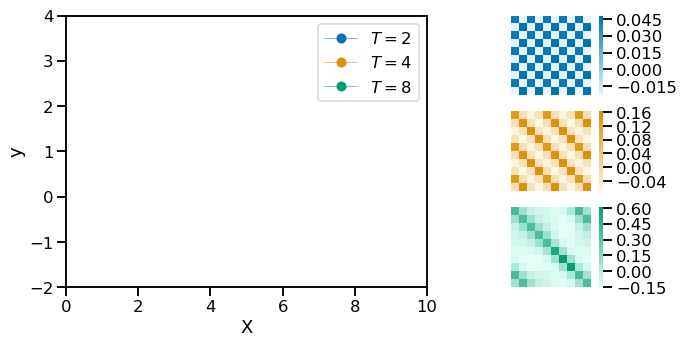

In [31]:
kernels=[]
lengthscales=[2,4,8]
x=np.arange(0,10)[:,None]
samples=[]
for i in range(0,len(lengthscales)):
    kernel = GPy.kern.PeriodicExponential(input_dim=1)
    X=np.array([[1.0],[10.0]])
    Y=np.array([[1.0],[1.0]])
    kernel.period.constrain_fixed(lengthscales[i])
    kernels.append(kernel)
    
    samples.append(kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=1, num_theta=40, diagrams='./diagrams'))
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(0,10)
lineplot.set_ylim(-2,4)
lineplot.set_xlabel('X')
lineplot.set_ylabel('y')
colors=sns.color_palette('colorblind')

cov_matrices=[]
for i in range(0,len(samples)):
    lines.append(lineplot.plot([], [],'o-', lw=0.5,color=colors[i],label=r'$T=$'+str(lengthscales[i]))[0])
    cov_matrices.append(fig.add_subplot(grid[i, 2]))
    sns.heatmap(kernels[i].K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrices[i],square=True,xticklabels=[],
            yticklabels=[])
    
lineplot.legend()    
def init():
    for s in range(0,len(samples)):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,len(samples)):
        lines[s].set_data(x,samples[s][:,i])
    return (lines)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples[0].shape[1], interval=100, blit=True)



In [32]:
anim

In [33]:
anim.save('./Slides/assets/periodic_exp_covfunc.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

## Brownian Motion

In [106]:
kernel = GPy.kern.Brownian(input_dim=1)

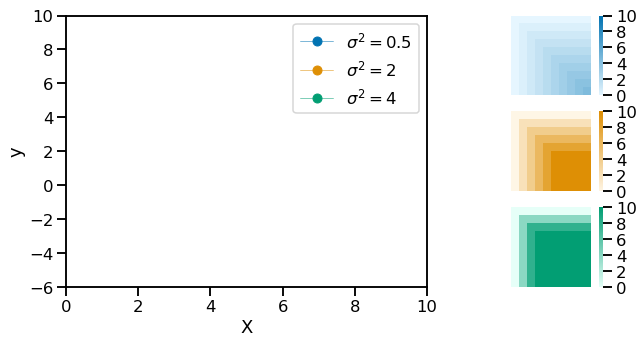

In [112]:
kernels=[]
lengthscales=[0.5,2,4]
x=np.arange(0,10)[:,None]
samples=[]
for i in range(0,len(lengthscales)):
    kernel = GPy.kern.Brownian(input_dim=1)
    X=np.array([[1.0],[10.0]])
    Y=np.array([[1.0],[1.0]])
    kernel.variance.constrain_fixed(lengthscales[i])
    kernels.append(kernel)
    
    samples.append(kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=1, num_theta=40, diagrams='./diagrams'))
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(0,10)
lineplot.set_ylim(-6,10)
lineplot.set_xlabel('X')
lineplot.set_ylabel('y')
colors=sns.color_palette('colorblind')

cov_matrices=[]
for i in range(0,len(samples)):
    lines.append(lineplot.plot([], [],'o-', lw=0.5,color=colors[i],label=r'$\sigma^2=$'+str(lengthscales[i]))[0])
    cov_matrices.append(fig.add_subplot(grid[i, 2]))
    sns.heatmap(kernels[i].K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrices[i],square=True,xticklabels=[],
            yticklabels=[],vmin=0,vmax=10)
    
lineplot.legend()    
def init():
    for s in range(0,len(samples)):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,len(samples)):
        lines[s].set_data(x,samples[s][:,i])
    return (lines)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples[0].shape[1], interval=100, blit=True)



In [113]:
anim

## Combined kernels

In [114]:
kernel = GPy.kern.PeriodicExponential(input_dim=1)+GPy.kern.RBF(input_dim=1)

In [ ]:
kernel.periodic_exponential

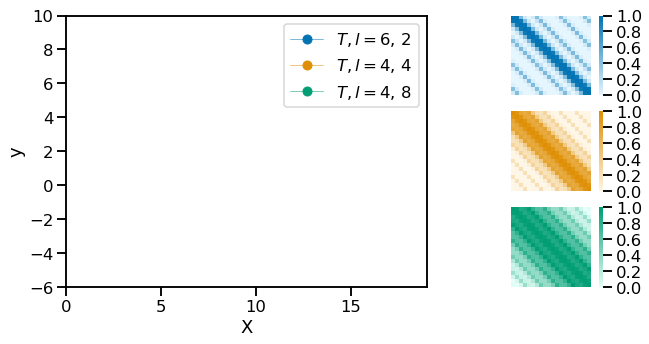

In [142]:
kernels=[]
lengthscales=[2,4,8]
periods=[6,4,4]
x=np.arange(0,20)[:,None]
samples=[]
for i in range(0,len(lengthscales)):
    kernel = GPy.kern.PeriodicExponential(input_dim=1)+GPy.kern.RBF(input_dim=1)
    X=np.array([[1.0],[10.0]])
    Y=np.array([[1.0],[1.0]])
    kernel.rbf.lengthscale.constrain_fixed(lengthscales[i])
    kernel.periodic_exponential.constrain_fixed(periods[i])
    kernels.append(kernel)
    
    samples.append(kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=1, num_theta=40, diagrams='./diagrams'))
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(0,x[-1])
lineplot.set_ylim(-6,10)
lineplot.set_xlabel('X')
lineplot.set_ylabel('y')
colors=sns.color_palette('colorblind')

cov_matrices=[]
for i in range(0,len(samples)):
    lines.append(lineplot.plot([], [],'o-', lw=0.5,color=colors[i],label=r'$T,l=$'+str(periods[i])+', '+str(lengthscales[i]))[0])
    cov_matrices.append(fig.add_subplot(grid[i, 2]))
    sns.heatmap(kernels[i].K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrices[i],square=True,xticklabels=[],
            yticklabels=[],vmin=0,vmax=1.0)
    
lineplot.legend()    
def init():
    for s in range(0,len(samples)):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,len(samples)):
        lines[s].set_data(x,samples[s][:,i])
    return (lines)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples[0].shape[1], interval=100, blit=True)



In [143]:
anim

In [144]:
anim.save('./Slides/assets/RBF_period_exp_covfunc.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

In [22]:
x=np.arange(0,10,0.5)[:,None]
samps_2=kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=5, num_theta=40, diagrams='./diagrams')

In [234]:
samps_2.shape

(20, 40, 5)

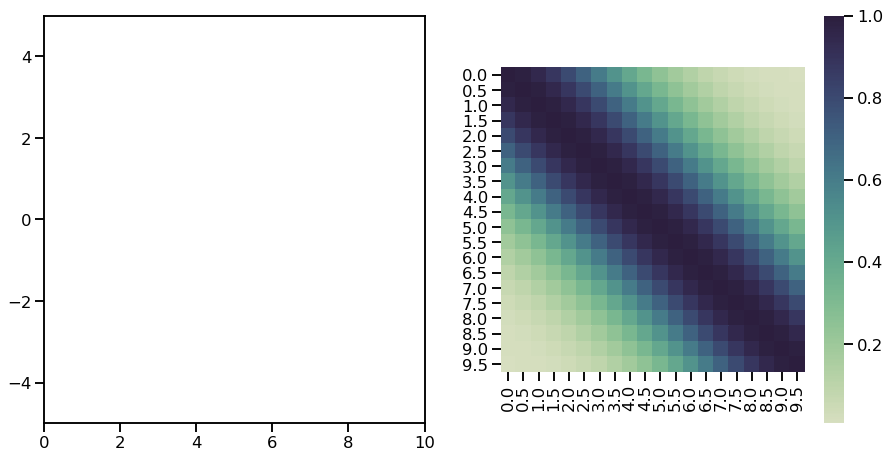

In [20]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
fig, ax = plt.subplots(1,2,figsize=(15,7.5),sharey=False,sharex=False)
lines=[]
colors=sns.color_palette('colorblind')
for i in range(samps_2.shape[2]):
    lines.append(ax[0].plot([], [],'-', lw=2,color=colors[i])[0])
    
ind=[0, 9]
ax[0].set_xlim(0,10)
ax[0].set_ylim(-5,5)

sns.heatmap(kernel.K(x),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True),ax=ax[1],square=True,xticklabels=x.flatten(),
            yticklabels=x.flatten())


def init():
    for s in range(0,samps_2.shape[2]):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samps_2.shape[2]):
        n_points=int(samps_2.shape[1]/2)
        if i <= n_points:
            lines[s].set_data(x[0:i],samps_2[0:i,i,s])
        else:
            lines[s].set_data(x[0:n_points-i],samps_2[0:n_points-i,i,s])
    return (lines)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samps_2.shape[1], interval=100, blit=True)

In [241]:
anim

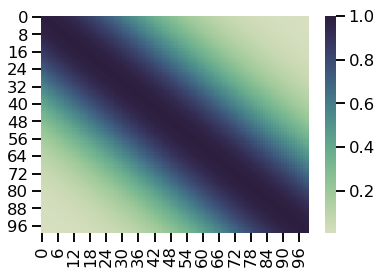

In [227]:
sns.heatmap(kernel.K(x),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True))

In [ ]:
sns.heatmap(kernel.K(x),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True))




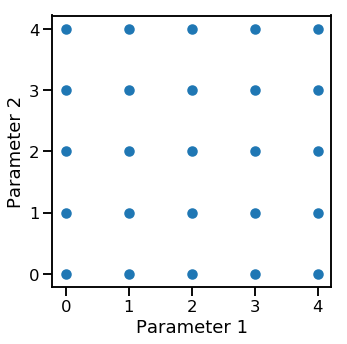

In [160]:
xx,yy=np.meshgrid(np.arange(0,5),np.arange(0,5))
plt.figure(figsize=(5,5))
plt.scatter(xx.flatten(),yy.flatten())
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.savefig('./Slides/assets/grid_search.png')

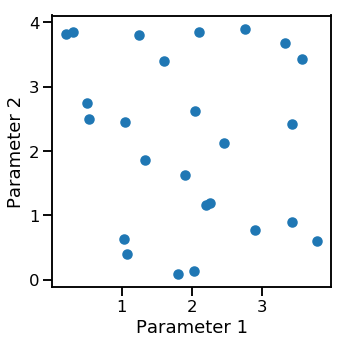

In [161]:
points=np.random.uniform(low=0,high=4,size=(25,2))
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1])
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.savefig('./Slides/assets/rand_search.png')

## Bayesian optimisation example

In [178]:
from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

target_function, space = forrester_function()

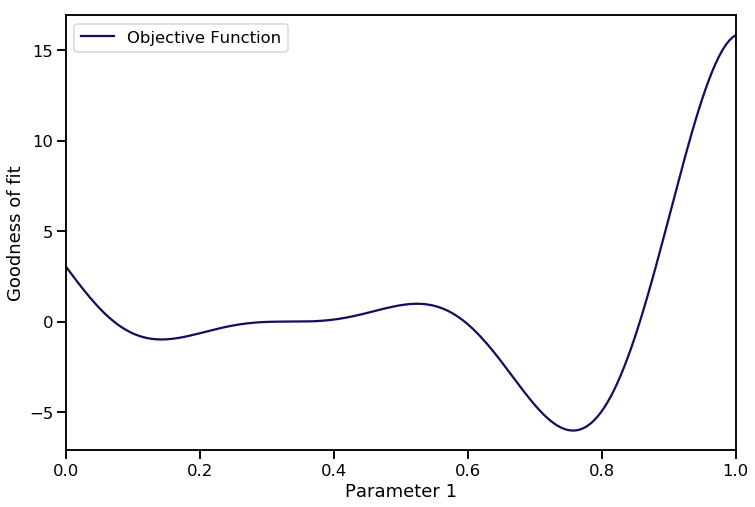

In [179]:
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
y_plot = target_function(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot, color1, label="Objective Function")
plt.legend(loc=2)
plt.xlabel(r"Parameter 1")
plt.ylabel(r"Goodness of fit")
#plt.grid(True)
plt.xlim(0, 1)
plt.savefig('./Slides/assets/BO_1.png')

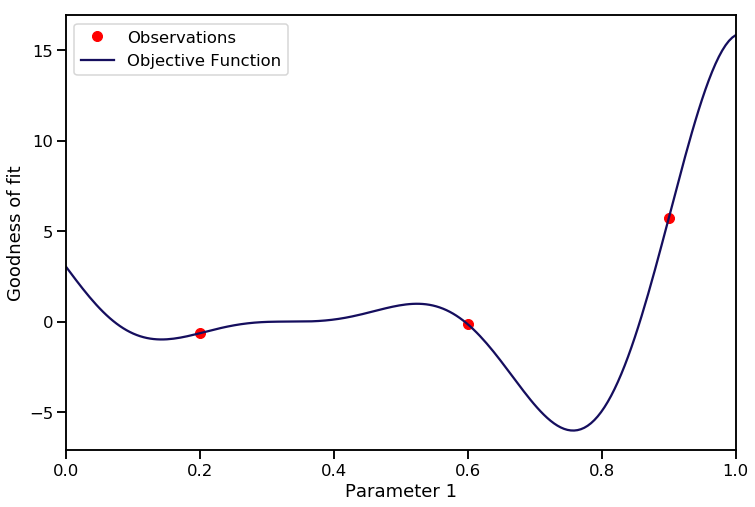

In [180]:
X_init = np.array([[0.2],[0.6], [0.9]])
Y_init = target_function(X_init)

plt.figure(figsize=(12, 8))
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, color1, label="Objective Function")
plt.legend(loc=2)
plt.xlabel(r"Parameter 1")
plt.ylabel(r"Goodness of fit")
#plt.grid(True)
plt.xlim(0, 1)
plt.savefig("./Slides/assets/BO_2.png")

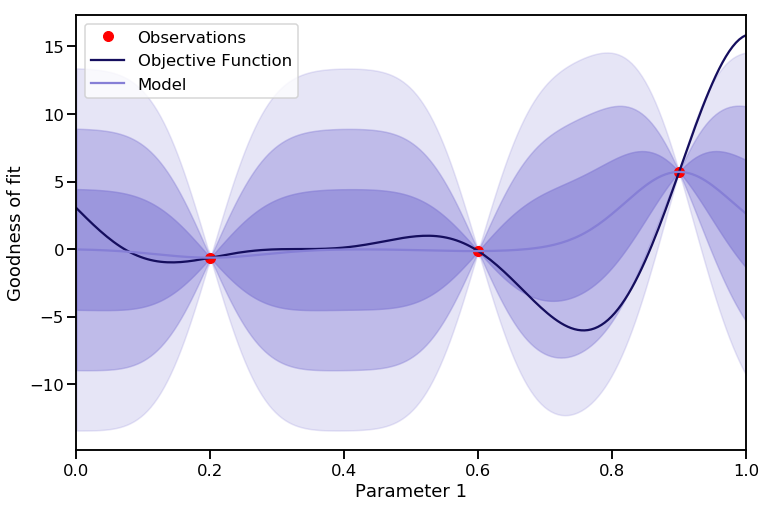

In [181]:
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, color1, label="Objective Function")
plt.plot(x_plot, mu_plot, color2, label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color=color2, alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color=color2, alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color=color2, alpha=0.2)
plt.legend(loc=2)
plt.xlabel(r"Parameter 1")
plt.ylabel(r"Goodness of fit")
#plt.grid(True)
plt.xlim(0, 1)
plt.savefig("./Slides/assets/BO_3.png")

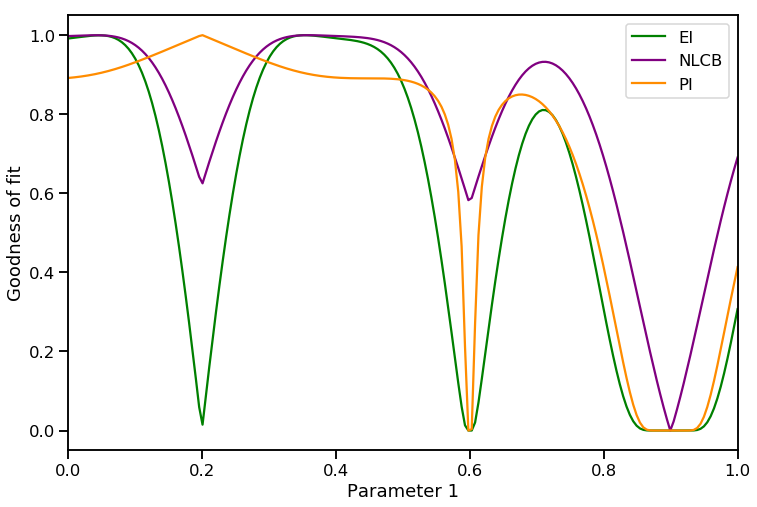

In [182]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

ei_acquisition = ExpectedImprovement(emukit_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
pi_acquisition = ProbabilityOfImprovement(emukit_model)

ei_plot = ei_acquisition.evaluate(x_plot)
nlcb_plot = nlcb_acquisition.evaluate(x_plot)
pi_plot = pi_acquisition.evaluate(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.plot(x_plot, (nlcb_plot - np.min(nlcb_plot)) / (np.max(nlcb_plot) - np.min(nlcb_plot)), "purple", label="NLCB")
plt.plot(x_plot, (pi_plot - np.min(pi_plot)) / (np.max(pi_plot) - np.min(pi_plot)), "darkorange", label="PI")

plt.legend(loc=1)
plt.xlabel(r"Parameter 1")
plt.ylabel(r"Goodness of fit")
plt.xlim(0, 1)
plt.savefig("./Slides/assets/BO_4.png")

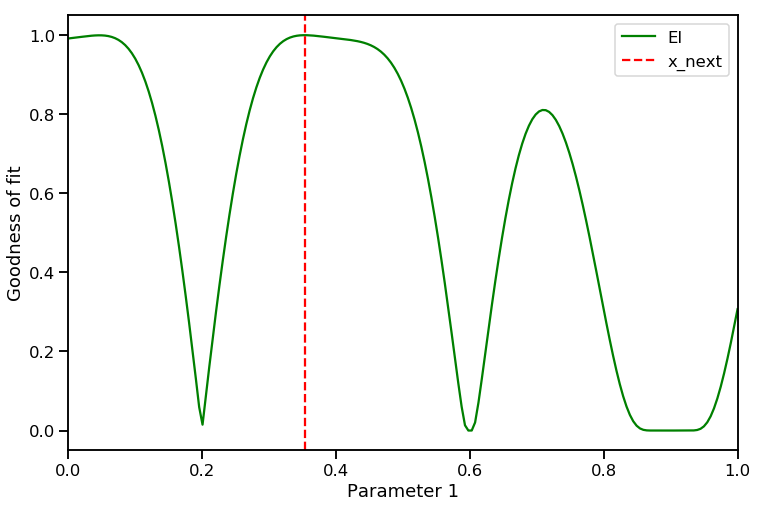

In [183]:
from emukit.core.optimization import AcquisitionOptimizer

optimizer = AcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(ei_acquisition)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.axvline(x_new, color="red", label="x_next", linestyle="--")
plt.legend(loc=1)
plt.xlabel(r"Parameter 1")
plt.ylabel(r"Goodness of fit")
plt.xlim(0, 1)
plt.savefig("./Slides/assets/BO_5.png")

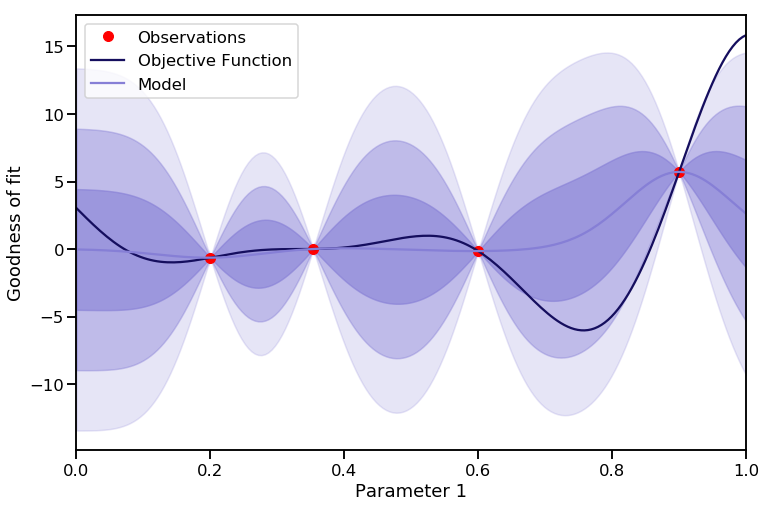

In [184]:
y_new = target_function(x_new)
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)
emukit_model.set_data(X, Y)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, color1, label="Objective Function")
plt.plot(x_plot, mu_plot, color2, label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color=color2, alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color=color2, alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color=color2, alpha=0.2)
plt.legend(loc=2)
plt.xlabel(r"Parameter 1")
plt.ylabel(r"Goodness of fit")
plt.xlim(0, 1)
plt.savefig("./Slides/assets/BO_6.png")

In [185]:
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization


bo = GPBayesianOptimization(variables_list=[ContinuousParameter('x1', 0, 1)],
                            X=X_init, Y=Y_init)
bo.run_optimization(target_function, 10)

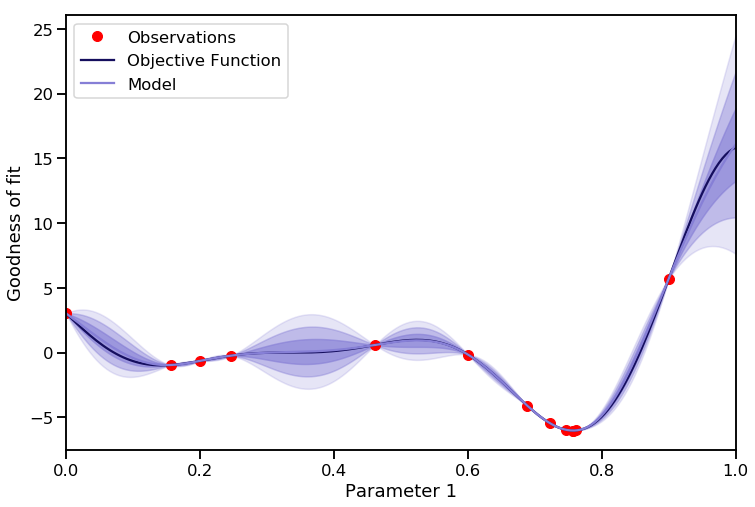

In [186]:
mu_plot, var_plot = bo.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(bo.loop_state.X, bo.loop_state.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, color1, label="Objective Function")
plt.plot(x_plot, mu_plot, color2, label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color=color2, alpha=0.6)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color=color2, alpha=0.4)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color=color2, alpha=0.2)
plt.legend(loc=2)

plt.xlim(0, 1)
plt.xlabel(r"Parameter 1")
plt.ylabel(r"Goodness of fit")
plt.savefig("./Slides/assets/BO_7.png")

## Fit GP to CO2

In [4]:
import pandas as pd

In [5]:
data=pd.read_csv('./Slides/assets/co2_mm_mlo.txt',skiprows=72,names=['year','month','yeardec','average','interp','trend','nodays'],delim_whitespace=True)

In [6]:
data

,year,month,yeardec,average,interp,trend,nodays
0,1958,3,1958.208,315.71,315.71,314.62,-1
1,1958,4,1958.292,317.45,317.45,315.29,-1
2,1958,5,1958.375,317.50,317.50,314.71,-1
3,1958,6,1958.458,-99.99,317.10,314.85,-1
4,1958,7,1958.542,315.86,315.86,314.98,-1
5,1958,8,1958.625,314.93,314.93,315.94,-1
6,1958,9,1958.708,313.20,313.20,315.91,-1
7,1958,10,1958.792,-99.99,312.66,315.61,-1
8,1958,11,1958.875,313.33,313.33,315.31,-1
9,1958,12,1958.958,314.67,314.67,315.61,-1


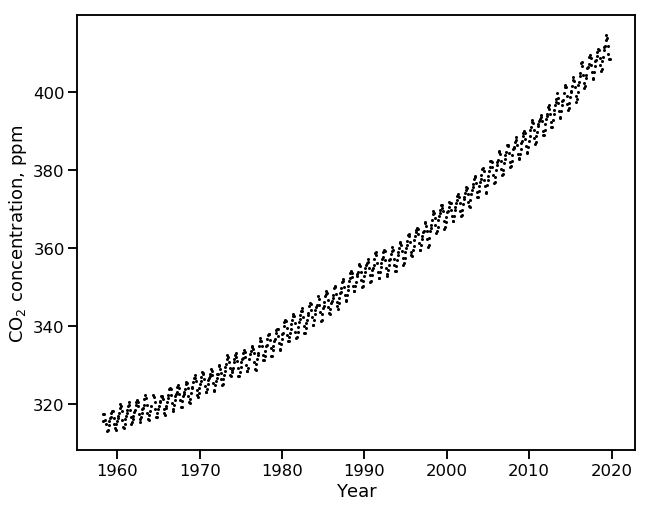

In [7]:
plt.figure(figsize=(10,8))
ind=data['average']>0
plt.plot(data['yeardec'][ind],data['average'][ind],'ko',markersize=2)
plt.xlabel('Year')
plt.ylabel('CO$_2$ concentration, ppm')
plt.savefig('./Slides/assets/co2data.png')

In [8]:
k1=GPy.kern.RBF(input_dim=1)
k2=GPy.kern.RBF(input_dim=1)*GPy.kern.StdPeriodic(input_dim=1)
k3=GPy.kern.RatQuad(input_dim=1)
k4=GPy.kern.RBF(input_dim=1)
k=k1+k2+k3+k4

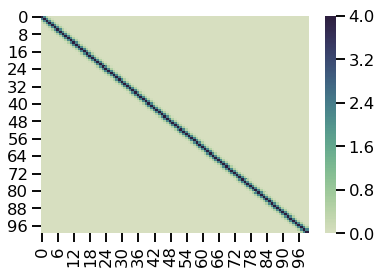

In [9]:
x=np.arange(0,100)[:,None]
sns.heatmap(k.K(x),cmap=sns.cubehelix_palette(start=.5, rot=-.75,as_cmap=True))

[<matplotlib.lines.Line2D object at 0x11d91c6a0>, <matplotlib.lines.Line2D object at 0x11d91c7b8>, <matplotlib.lines.Line2D object at 0x11d91cb00>, <matplotlib.lines.Line2D object at 0x11d91ce48>]


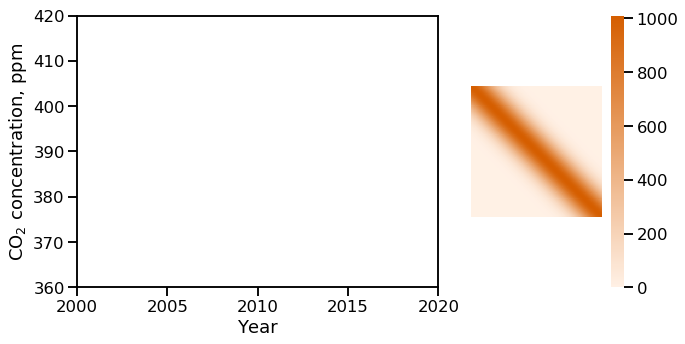

In [22]:

x=np.arange(2000,2020,1.0/12)[:,None]

    
samples=kern_circular_sample(k.K(x), mu=0.0, filename=None, fig=None, num_samps=4, num_theta=40, diagrams='./diagrams')
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(2000,2020)
lineplot.set_ylim(360,420)
lineplot.set_xlabel('Year')
lineplot.set_ylabel('CO$_2$ concentration, ppm')

colors=sns.color_palette('colorblind')

for i in range(0,samples.shape[2]):
    lines.append(lineplot.plot([], [], lw=1.0,color=colors[i])[0])
cov_matrix=fig.add_subplot(grid[:, 2])
sns.heatmap(k.K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrix,square=True,xticklabels=[],
            yticklabels=[])

print(lines)
def init():
    for s in range(0,samples.shape[2]):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samples.shape[2]):
        lines[s].set_data(x,samples[:,i,s]+np.mean(data['average'].values[ind]))
    return (lines)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples.shape[1], interval=100, blit=True)



In [23]:
anim

In [24]:
anim.save('./Slides/assets/co2_nodata.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

In [9]:
X=data['yeardec'].values[ind,None]
Y=data['average'].values[ind,None]-np.mean(data['average'].values[ind])

In [15]:
X[-120:-118]

array([[2009.875],
       [2009.958]])

In [16]:
m=GPy.models.GPRegression(X[-120:-118],Y[-120:-118],kernel=k)

In [17]:
m.optimize_restarts(10)

Optimization restart 1/10, f = 6.633428549905431
Optimization restart 2/10, f = 6.633428549598333
Optimization restart 3/10, f = 6.633428549690257
Optimization restart 4/10, f = 6.633428549577729
Optimization restart 5/10, f = 6.633428549589624
Optimization restart 6/10, f = 6.633428549577985
Optimization restart 7/10, f = 6.633428549587203
Optimization restart 8/10, f = 6.633428552043728
Optimization restart 9/10, f = 6.633428549630315
Optimization restart 10/10, f = 6.633428552456342


In [18]:
m

GP_regression.,value,constraints,priors
sum.rbf.variance,1.74718732522888,+ve,
sum.rbf.lengthscale,1.2353172922304678,+ve,
sum.mul.rbf.variance,32.41155425279961,+ve,
sum.mul.rbf.lengthscale,2.520702798547159,+ve,
sum.mul.std_periodic.variance,30.916378510033653,+ve,
sum.mul.std_periodic.period,6.08013676267927,+ve,
sum.mul.std_periodic.lengthscale,6.029270463945922,+ve,
sum.RatQuad.variance,5.564528719736639,+ve,
sum.RatQuad.lengthscale,0.2981096702432398,+ve,
sum.RatQuad.power,0.358980344469334,+ve,


[<matplotlib.lines.Line2D object at 0x11d3a8278>, <matplotlib.lines.Line2D object at 0x11d3a8390>, <matplotlib.lines.Line2D object at 0x11d3a86d8>, <matplotlib.lines.Line2D object at 0x11d3a8a20>]


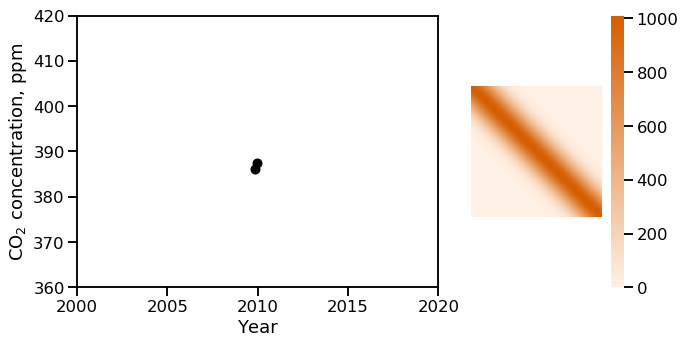

In [19]:

x=np.arange(2000,2020,1.0/12)[:,None]

    
samples=get_circular_samples(X[-120:-118],Y[-120:-118],x,m,num_theta=40,num_samps=4)
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(2000,2020)
lineplot.set_ylim(360,420)
lineplot.set_xlabel('Year')
lineplot.set_ylabel('CO$_2$ concentration, ppm')
colors=sns.color_palette('colorblind')

for i in range(0,samples.shape[2]):
    lines.append(lineplot.plot([], [], lw=1.0,color=colors[i])[0])
cov_matrix=fig.add_subplot(grid[:, 2])
sns.heatmap(k.K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrix,square=True,xticklabels=[],
            yticklabels=[])

print(lines)
def init():
    for s in range(0,samples.shape[2]):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samples.shape[2]):
        lines[s].set_data(x,samples[:,i,s]+np.mean(data['average'].values[ind]))
    return (lines)
lineplot.plot(X[-120:-118],Y[-120:-118]+np.mean(data['average'].values[ind]),'ko')

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples.shape[1], interval=100, blit=True)



In [20]:
anim

In [21]:
anim.save('./Slides/assets/co2_twopoints.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

In [10]:
ind_eg=[-230,-229,-120,-119,-30,-29]

In [11]:
m=GPy.models.GPRegression(X[ind_eg],Y[ind_eg],kernel=k)

In [12]:
m.optimize_restarts(10)

 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 1/10, f = 14.837994001286116
Optimization restart 2/10, f = 14.87320299301535
Optimization restart 3/10, f = 14.838794117706838
Optimization restart 4/10, f = 15.499565778697917
Optimization restart 5/10, f = 14.838351016870654


 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/standard_periodic.py:151: RuntimeWarning:overflow encountered in square
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:divide by zero encountered in true_divide
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:invalid value encountered in multiply
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/standard_periodic.py:155: RuntimeWarning:divide by zero encountered in true_divide
 /Users/pdh21/an

Optimization restart 6/10, f = 14.733448293533133
Optimization restart 7/10, f = 14.839349359749116
Optimization restart 8/10, f = 15.987955299498548

 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply



Optimization restart 9/10, f = 14.839528500551683
Optimization restart 10/10, f = 14.815967982299927


 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/stationary.py:683: RuntimeWarning:overflow encountered in multiply
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/stationary.py:683: RuntimeWarning:invalid value encountered in multiply
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-1.9.6-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/stationary.py:688: RuntimeWarning:overflow encountered in square
 /Users/pdh21/anaconda3/envs/ambiental/lib/python3.6/site-packages/GPy-

In [13]:
m

GP_regression.,value,constraints,priors
sum.rbf.variance,0.07890522938914579,+ve,
sum.rbf.lengthscale,1.3593127359041106,+ve,
sum.mul.rbf.variance,57.510011355713246,+ve,
sum.mul.rbf.lengthscale,46.19733725571774,+ve,
sum.mul.std_periodic.variance,57.47389731261865,+ve,
sum.mul.std_periodic.period,2.1818799452259134,+ve,
sum.mul.std_periodic.lengthscale,7.554443751919757,+ve,
sum.RatQuad.variance,3.4761206413490746,+ve,
sum.RatQuad.lengthscale,1.4859315407283955,+ve,
sum.RatQuad.power,0.0425409595062105,+ve,


[<matplotlib.lines.Line2D object at 0x107d12438>, <matplotlib.lines.Line2D object at 0x107d12550>, <matplotlib.lines.Line2D object at 0x107d12898>, <matplotlib.lines.Line2D object at 0x107d12be0>]


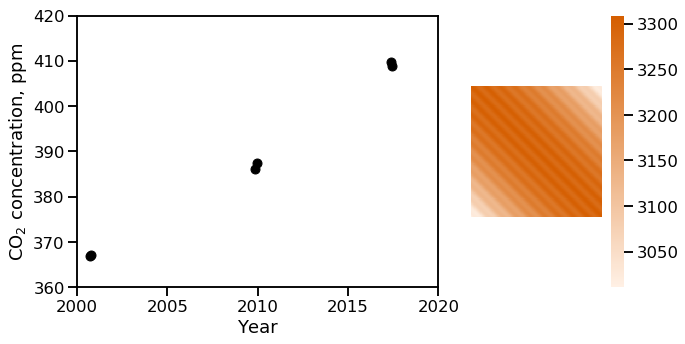

In [14]:
x=np.arange(2000,2020,1.0/12)[:,None]

    
samples=get_circular_samples(X[ind_eg],Y[ind_eg],x,m,num_theta=40,num_samps=4)
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(2000,2020)
lineplot.set_ylim(360,420)
lineplot.set_xlabel('Year')
lineplot.set_ylabel('CO$_2$ concentration, ppm')
colors=sns.color_palette('colorblind')

for i in range(0,samples.shape[2]):
    lines.append(lineplot.plot([], [], lw=1.0,color=colors[i])[0])
cov_matrix=fig.add_subplot(grid[:, 2])
sns.heatmap(k.K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrix,square=True,xticklabels=[],
            yticklabels=[])

print(lines)
def init():
    for s in range(0,samples.shape[2]):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samples.shape[2]):
        lines[s].set_data(x,samples[:,i,s]+np.mean(data['average'].values[ind]))
    return (lines)
lineplot.plot(X[ind_eg],Y[ind_eg]+np.mean(data['average'].values[ind]),'ko')

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples.shape[1], interval=100, blit=True)



In [15]:
anim

In [16]:
anim.save('./Slides/assets/co2_fourpoints.mp4',fps=10,extra_args=['-vcodec', 'libx264'])

In [28]:
m=GPy.models.GPRegression(X,Y,kernel=k)

In [29]:
m.optimize_restarts(10)

Optimization restart 1/10, f = 213.0497732129087
Optimization restart 2/10, f = 239.5828155114492
Optimization restart 3/10, f = 766.1804214264271
Optimization restart 4/10, f = 239.1474009353654
Optimization restart 5/10, f = 767.8636543926534
Optimization restart 6/10, f = 767.4880586272504
Optimization restart 7/10, f = 501.4847837915803
Optimization restart 8/10, f = 618.7686784360654
Optimization restart 9/10, f = 767.1241418157927
Optimization restart 10/10, f = 506.52364121712344


In [30]:
m

GP_regression.,value,constraints,priors
sum.rbf.variance,130.19350211000796,+ve,
sum.rbf.lengthscale,23.358158819909868,+ve,
sum.mul.rbf.variance,222.1928814797804,+ve,
sum.mul.rbf.lengthscale,376.01919802137604,+ve,
sum.mul.std_periodic.variance,222.1928815038371,+ve,
sum.mul.std_periodic.period,0.9999785774162565,+ve,
sum.mul.std_periodic.lengthscale,2.560000683251414,+ve,
sum.RatQuad.variance,110.18075562603993,+ve,
sum.RatQuad.lengthscale,0.12293216974054702,+ve,
sum.RatQuad.power,0.0003278329527421252,+ve,


In [31]:
x=np.arange(1959,2030,1.0/12)[:,None]

    
samples=get_circular_samples(X,Y,x,m,num_theta=40,num_samps=4)
    
# Set up the axes with gridspec
fig = plt.figure(figsize=(10, 5))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)



lineplot=fig.add_subplot(grid[:, 0:2])
lines=[]
points=[]

lineplot.set_xlim(2000,2020)
lineplot.set_ylim(360,420)
lineplot.set_xlabel('Year')
lineplot.set_ylabel('CO$_2$ concentration, ppm')
colors=sns.color_palette('colorblind')

for i in range(0,samples.shape[2]):
    lines.append(lineplot.plot([], [], lw=1.0,color=colors[i])[0])
cov_matrix=fig.add_subplot(grid[:, 2])
sns.heatmap(k.K(x),cmap=sns.light_palette(colors[i], input="rgb",as_cmap=True),ax=cov_matrix,square=True,xticklabels=[],
            yticklabels=[])

print(lines)
def init():
    for s in range(0,samples.shape[2]):
        lines[s].set_data([], [])
    return (lines)

# animation function. This is called sequentially
def animate(i):
    for s in range(0,samples.shape[2]):
        lines[s].set_data(x,samples[:,i,s]+np.mean(data['average'].values[ind]))
    return (lines)
lineplot.plot(X,Y+np.mean(data['average'].values[ind]),'ko',markersize=0.2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples.shape[1], interval=100, blit=True)



LinAlgError: Matrix is not positive definite

In [32]:
mu,var=m.predict(data['yeardec'].values[:,None])

In [43]:
X_pred=np.arange(2020,2040,1/12.0)[:,None]
mu_pred,var_pred=m.predict(X_pred)

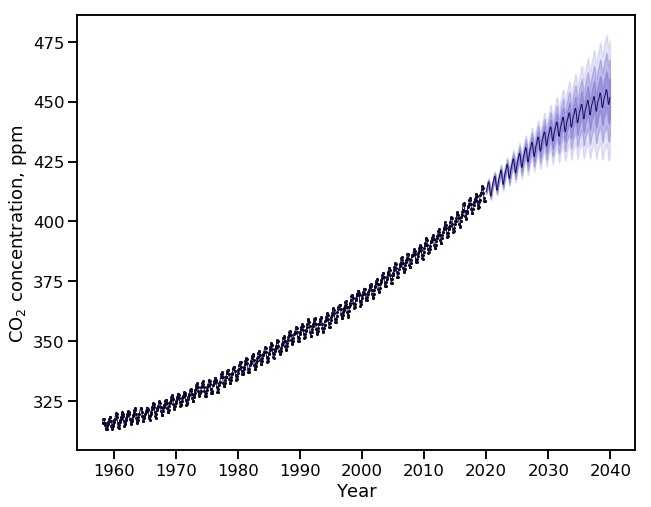

In [47]:
plt.figure(figsize=(10,8))
ind=data['average']>0
plt.plot(data['yeardec'][ind],data['average'][ind],'ko',markersize=2)
plt.plot(data['yeardec'],mu+np.mean(data['average'].values[ind]),lw=1.0,color=color1)
plt.plot(X_pred,mu_pred+np.mean(data['average'].values[ind]),lw=1.0,color=color1)

plt.fill_between(X_pred[:, 0],
                 mu_pred[:, 0]+np.mean(data['average'].values[ind]) + np.sqrt(var_pred)[:, 0],
                 mu_pred[:, 0]+np.mean(data['average'].values[ind]) - np.sqrt(var_pred)[:, 0], color=color2, alpha=0.6)

plt.fill_between(X_pred[:, 0],
                 mu_pred[:, 0]+np.mean(data['average'].values[ind]) + 2 * np.sqrt(var_pred)[:, 0],
                 mu_pred[:, 0]+np.mean(data['average'].values[ind]) - 2 * np.sqrt(var_pred)[:, 0], color=color2, alpha=0.4)

plt.fill_between(X_pred[:, 0],
                 mu_pred[:, 0]+np.mean(data['average'].values[ind]) + 3 * np.sqrt(var_pred)[:, 0],
                 mu_pred[:, 0]+np.mean(data['average'].values[ind]) - 3 * np.sqrt(var_pred)[:, 0], color=color2, alpha=0.2)

plt.xlabel('Year')
plt.ylabel('CO$_2$ concentration, ppm')
plt.savefig('./Slides/assets/co2fit_and_pred.png')

In [255]:
k

sum.,value,constraints,priors
rbf.variance,30.06804678843553,+ve,
rbf.lengthscale,17.554010953755505,+ve,
mul.rbf.variance,115.8697607985926,+ve,
mul.rbf.lengthscale,152.10871432802892,+ve,
mul.std_periodic.variance,129.4119428887816,+ve,
mul.std_periodic.period,0.9998866947516198,+ve,
mul.std_periodic.lengthscale,2.282490962278834,+ve,
RatQuad.variance,119.99425044755951,+ve,
RatQuad.lengthscale,0.12235402546771537,+ve,
RatQuad.power,0.00029853617330367747,+ve,


In [232]:
x=np.arange(2000,2020,1.0/12)[:,None]

    
samples=kern_circular_sample(kernel.K(x), mu=0.0, filename=None, fig=None, num_samps=4, num_theta=40, diagrams='./diagrams')


In [234]:
samples.shape

(240, 40, 4)